<a href="https://colab.research.google.com/github/leopomme/Dose-Prediction-Segmentation/blob/main/notebook_DLMI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import StepLR

import time 
from tqdm import tqdm
from glob import glob
import zipfile
import shutil


In [14]:
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

fatal: destination path 'MVA-Dose-Prediction' already exists and is not an empty directory.


In [15]:
transform_img = A.Compose([
    A.OneOf([
        A.GaussNoise(var_limit=(0, 25), p=1),
        A.Blur(blur_limit=(3, 10), p=1),
    ], p=0.5),
])

transform_img_mask = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=14, sigma=5, alpha_affine=5, p=1),
        A.Rotate(limit=10, p=1),
        A.VerticalFlip(p=1),
        A.GridDistortion(num_steps=10, distort_limit=0.5, p=1),
    ], p=0.5),
])


train_transforms = {
    'img': transform_img,
    'img_mask': transform_img_mask
}

val_transforms = None


In [16]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.samples = os.listdir(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.data_path + os.sep + self.samples[idx]
        ct_scan = np.load(sample_path + os.sep + 'ct.npy')
        possible_dose_mask = np.load(sample_path + os.sep + 'possible_dose_mask.npy')
        dose = np.load(sample_path + os.sep + 'dose.npy')
        structure_masks = np.load(sample_path + os.sep + 'structure_masks.npy')

        combined_masks = [possible_dose_mask] + [structure_masks[i] for i in range(structure_masks.shape[0])] + [dose]

        if self.transform:
            if 'img_mask' in self.transform:
                transform_func = self.transform['img_mask']
                augmentations = transform_func(image=ct_scan, masks=combined_masks)
                ct_scan = augmentations['image']
                combined_masks = augmentations['masks']
            if 'img' in self.transform:
                transform_func = self.transform['img']
                augmentations = transform_func(image=ct_scan)
                ct_scan = augmentations['image']

        # Convert NumPy arrays to PyTorch tensors
        ct_scan_tensor = torch.from_numpy(ct_scan).float().unsqueeze(0)
        combined_masks_tensor = torch.from_numpy(np.stack(combined_masks[:-1], axis=0)).float()
        dose_tensor = torch.from_numpy(combined_masks[-1]).float().unsqueeze(0)

        # Normalize the ct_scan tensor
        mean = ct_scan_tensor.mean()
        std = ct_scan_tensor.std()
        normalize = transforms.Normalize(mean=[mean], std=[std+1e-6])
        ct_scan_tensor = normalize(ct_scan_tensor)

        # Combine ct_scan_tensor and combined_masks_tensor
        input_image = torch.cat([ct_scan_tensor, combined_masks_tensor], dim=0)

        return {'input_image': input_image, 'dose': dose_tensor}


In [17]:
class test_DoseDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.samples = os.listdir(data_path)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.data_path + os.sep + self.samples[idx]
        ct_scan = np.load(sample_path + os.sep + 'ct.npy')
        possible_dose_mask = np.load(sample_path + os.sep + 'possible_dose_mask.npy')
        structure_masks = np.load(sample_path + os.sep + 'structure_masks.npy')
        combined_masks = [possible_dose_mask] + [structure_masks[i] for i in range(structure_masks.shape[0])]

        # Convert NumPy arrays to PyTorch tensors
        ct_scan_tensor = torch.from_numpy(ct_scan).float().unsqueeze(0)
        combined_masks_tensor = torch.from_numpy(np.stack(combined_masks, axis=0)).float()

        # Normalize the ct_scan tensor
        mean = ct_scan_tensor.mean()
        std = ct_scan_tensor.std()
        normalize = transforms.Normalize(mean=[mean], std=[std+1e-6])
        ct_scan_tensor = normalize(ct_scan_tensor)

        # Combine ct_scan_tensor and combined_masks_tensor
        input_image = torch.cat([ct_scan_tensor, combined_masks_tensor], dim=0)

        return {'sample_name': self.samples[idx], 'input_image': input_image}


In [18]:
from torch.utils.data import ConcatDataset

train_dir = "./MVA-Dose-Prediction/train/"

train_dataset_original = DoseDataset(train_dir, transform=None)
train_dataset_augmented = DoseDataset(train_dir, transform=train_transforms)

train_dataset = ConcatDataset([train_dataset_original, train_dataset_augmented])

train_dataloader = DataLoader(train_dataset_augmented, batch_size=16, num_workers=2, shuffle=True, pin_memory=True)
print(len(train_dataloader))


488


In [19]:
val_dir = "./MVA-Dose-Prediction/validation/"

val_dataset = DoseDataset(val_dir, transform=val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=2, shuffle=True, pin_memory=True)
print(len(val_dataloader))

75


In [20]:
test_dir = "./MVA-Dose-Prediction/test"

test_dataset = test_DoseDataset(test_dir)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=2, shuffle=True, pin_memory=True)
print(len(test_dataloader))

75


In [21]:
class BigBasicBlock(nn.Module):
    def __init__(self, in_channels: int, forward_expansion: int, out_channels: int):
        super(BigBasicBlock, self).__init__()
 
        self.conv1 = nn.Conv2d(in_channels, forward_expansion, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(forward_expansion)
        self.conv2 = nn.Conv2d(forward_expansion, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = nn.Dropout(0.1)(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = nn.ReLU()(out)
        out = nn.Dropout(0.125)(out)
        return out

class BigUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(BigUNet, self).__init__()

        # Downward pass

        self.first = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.down1 = nn.Sequential(
            BigBasicBlock(64, 64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.down2 = nn.Sequential(
            BigBasicBlock(128, 128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.down3 = nn.Sequential(
            BigBasicBlock(256, 256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.down4 = nn.Sequential(
            BigBasicBlock(512, 512, 1024),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Bottom block
        self.bottom = BigBasicBlock(1024, 1024, 1024)

        # Upward pass
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(1024+1024, 512, kernel_size=2, stride=2),
            BigBasicBlock(512, 512, 512),
        )

        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(512+512, 256, kernel_size=2, stride=2),
            BigBasicBlock(256, 256, 256),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256 + 256, 128, kernel_size=2, stride=2),
            BigBasicBlock(128, 128, 128),
        )
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        )

        self.last = nn.Sequential(
            nn.Conv2d(32 + in_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(4, 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1)  
        )

    def forward(self, x):
      # Downward pass
      x_initial = self.first(x)
      x1 = self.down1(x_initial)
      x2 = self.down2(x1)
      x3 = self.down3(x2)
      x4 = self.down4(x3)

      # Bottom block
      bottom = self.bottom(x4)

      # Upward pass
      y4 = self.up4(torch.cat((bottom, x4), dim=1))
      y3 = self.up3(torch.cat((y4, x3), dim=1))
      y2 = self.up2(torch.cat((y3, x2), dim=1))
      y1 = self.up1(torch.cat((y2, x1), dim=1))
      
      # Concatenate input layer
      y_concat = torch.cat((y1, x), dim=1)
      y = self.last(y_concat)
      y = nn.ReLU()(y)

      y = y * x[:, 1:2, :, :]

      return y



In [22]:
# Create a training loop
# def train(model, dataloader, criterion, optimizer, device, l1_reg_factor):
def train(model, dataloader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data['input_image'].to(device), data['dose'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # # Add the L1 penalty to the loss
        # l1_penalty = 0
        # for param in model.parameters():
        #     l1_penalty += torch.sum(torch.abs(param))
        # loss += l1_reg_factor * l1_penalty

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / (i + 1)

# Create a validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data['input_image'].to(device), data['dose'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / (i + 1)


In [23]:
class EarlyStopping:
  def __init__(self, patience = 5):
    self.patience = patience
    self.best_val_loss = None
    self.counter = 0
    self.early_stop = False

  def __call__(self, val_loss):
    if self.best_val_loss is None or val_loss < self.best_val_loss:
        self.best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_trained_model.pth')
        print('model saved')
        self.counter = 0
    else:
        self.counter += 1

In [24]:
# Train the model and evaluate its performance on the validation set
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BigUNet().to(device)
criterion = nn.L1Loss()
# l1_reg_factor = 0.0001
l2_reg_factor = 0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_reg_factor)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience = 10)

real_num_epoch = 0
train_loss_list = []
val_loss_list = []

start_time = time.time()

for epoch in range(num_epochs):
    epoch_time = time.time()

    # train_loss = train(model, train_dataloader, criterion, optimizer, l1_reg_factor, device)
    train_loss = train(model, train_dataloader, criterion, optimizer, device)

    val_loss = validate(model, val_dataloader, criterion, device)

    elapsed_time = time.time() - epoch_time
    total_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch time: {elapsed_time/60:.2f}min, Total time: {total_time/60:.2f}min')
    real_num_epoch +=1

    # Update the learning rate using the scheduler
    scheduler.step()

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    early_stopping(val_loss)
    if early_stopping.counter >= early_stopping.patience:
      print(f'Early stopping at epoch {epoch + 1}. Best epoch: {epoch + 1 - early_stopping.counter} with Val Loss: {early_stopping.best_val_loss:.4f}')
      break

cuda
Epoch 1/100, Train Loss: 0.7733, Val Loss: 0.4852, Epoch time: 2.76min, Total time: 2.76min
model saved
Epoch 2/100, Train Loss: 0.5282, Val Loss: 0.5677, Epoch time: 2.80min, Total time: 5.57min
Epoch 3/100, Train Loss: 0.4997, Val Loss: 0.4960, Epoch time: 2.83min, Total time: 8.40min
Epoch 4/100, Train Loss: 0.4897, Val Loss: 0.4368, Epoch time: 2.80min, Total time: 11.21min
model saved
Epoch 5/100, Train Loss: 0.4731, Val Loss: 0.4819, Epoch time: 2.79min, Total time: 14.01min
Epoch 6/100, Train Loss: 0.4575, Val Loss: 0.4498, Epoch time: 2.84min, Total time: 16.85min
Epoch 7/100, Train Loss: 0.4376, Val Loss: 0.4294, Epoch time: 2.87min, Total time: 19.72min
model saved
Epoch 8/100, Train Loss: 0.4283, Val Loss: 0.4184, Epoch time: 2.79min, Total time: 22.51min
model saved
Epoch 9/100, Train Loss: 0.4267, Val Loss: 0.4728, Epoch time: 2.82min, Total time: 25.34min
Epoch 10/100, Train Loss: 0.4216, Val Loss: 0.4077, Epoch time: 2.80min, Total time: 28.15min
model saved
Epoch 1

<function matplotlib.pyplot.show(close=None, block=None)>

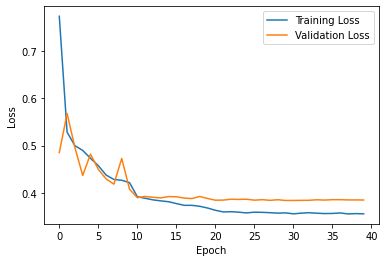

In [25]:
plt.plot(range(real_num_epoch), train_loss_list, label='Training Loss')
plt.plot(range(real_num_epoch), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [26]:
model.eval()

# Create a directory to store the predicted dose files
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Loop through the test dataset and make predictions
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        sample_names = data['sample_name']
        inputs = data['input_image'].to(device)
        outputs = model(inputs)
        
        batch_outputs = outputs.cpu().numpy()
        
        # Save each sample's prediction separately
        for i, sample_name in enumerate(sample_names):
            output_file = os.path.join(output_dir, f'{sample_name}.npy')
            np.save(output_file, batch_outputs[i])

# Create a zip file with all the predicted dose files
with zipfile.ZipFile("submission.zip", "w") as zf:
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        zf.write(file_path, arcname=file)



In [27]:
model.load_state_dict(torch.load('best_trained_model.pth'))
model.eval()

# Create a directory to store the predicted dose files
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Loop through the test dataset and make predictions
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        sample_names = data['sample_name']
        inputs = data['input_image'].to(device)
        outputs = model(inputs)
        
        batch_outputs = outputs.cpu().numpy()
        
        # Save each sample's prediction separately
        for i, sample_name in enumerate(sample_names):
            output_file = os.path.join(output_dir, f'{sample_name}.npy')
            np.save(output_file, batch_outputs[i])

# Create a zip file with all the predicted dose files
with zipfile.ZipFile("submission.zip", "w") as zf:
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        zf.write(file_path, arcname=file)
